In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
# Example values

In [4]:
import numpy as np
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def get_data(lag = 27, reshape = True):
    df = pd.read_csv('data.csv')
    df.drop('Unnamed: 0', inplace = True, axis = 1)
    df.columns = ['Date', 'sfu']
    df.Date = pd.to_datetime(df.Date)
    train_data = df[(df['Date'].dt.year < 2003) & (df['Date'].dt.year > 1979)]
    test_data = df[(df['Date'].dt.year >= 2003) & (df['Date'].dt.year <= 2014)]    
    train_X, train_y = split_sequence(np.array(train_data['sfu']), lag)
    test_X, test_y = split_sequence(np.array(test_data['sfu']), lag)
    if reshape:    
        train_X = train_X.reshape((train_X.shape[0], lag, 1))
        test_X = test_X.reshape((test_X.shape[0], lag, 1))
    return train_X, train_y, test_X, test_y
    

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

def get_data_CNN(lag = 27, reshape = True):
    df = pd.read_csv('data.csv')
    df.drop('Unnamed: 0', inplace = True, axis = 1)
    df.columns = ['Date', 'sfu']
    df.Date = pd.to_datetime(df.Date)
    train_data = df[(df['Date'].dt.year < 2003) & (df['Date'].dt.year > 1979)]
    test_data = df[(df['Date'].dt.year >= 2003) & (df['Date'].dt.year <= 2014)]    
    train_X, train_y = split_sequence(np.array(train_data['sfu']), lag)
    test_X, test_y = split_sequence(np.array(test_data['sfu']), lag)
    if reshape:    
        train_X = train_X.reshape((train_X.shape[0],1, lag, 1))
        test_X = test_X.reshape((test_X.shape[0],1, lag, 1))
    return train_X, train_y, test_X, test_y
    

In [78]:
import numpy as np
def split_sequences_multistep(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(n_steps_in, len(sequences)-n_steps_out):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i-n_steps_in:i], sequences[i: i+ n_steps_out]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [76]:
def get_data_multistep(in_steps, out_steps, reshape = True):
    X, y = list(), list()
    df = pd.read_csv('data.csv')
    df.drop('Unnamed: 0', inplace = True, axis = 1)
    df.columns = ['Date', 'sfu']
    df.Date = pd.to_datetime(df.Date)
    train_data = df[(df['Date'].dt.year < 2003) & (df['Date'].dt.year > 1979)]
    test_data = df[(df['Date'].dt.year >= 2003) & (df['Date'].dt.year <= 2014)]    
    train_X, train_y = split_sequences_multistep(np.array(train_data['sfu']), in_steps, out_steps)
    test_X, test_y = split_sequences_multistep(np.array(test_data['sfu']), in_steps, out_steps)
    if reshape:    
        train_X = train_X.reshape((train_X.shape[0],in_steps,1))
        test_X = test_X.reshape((test_X.shape[0], in_steps, 1))
    return train_X, train_y, test_X, test_y
    

    

In [102]:
def get_CNN_data_multistep(in_steps, out_steps, reshape = True):
    X, y = list(), list()
    df = pd.read_csv('data.csv')
    df.drop('Unnamed: 0', inplace = True, axis = 1)
    df.columns = ['Date', 'sfu']
    df.Date = pd.to_datetime(df.Date)
    train_data = df[(df['Date'].dt.year < 2003) & (df['Date'].dt.year > 1979)]
    test_data = df[(df['Date'].dt.year >= 2003) & (df['Date'].dt.year <= 2014)]    
    train_X, train_y = split_sequences_multistep(np.array(train_data['sfu']), in_steps, out_steps)
    test_X, test_y = split_sequences_multistep(np.array(test_data['sfu']), in_steps, out_steps)
    if reshape:    
        train_X = train_X.reshape((train_X.shape[0], 1, in_steps,1))
        test_X = test_X.reshape((test_X.shape[0], 1, in_steps, 1))
    return train_X, train_y, test_X, test_y

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pathlib

class MLP():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'MLP.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, lag):
        model = model = Sequential()
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')

        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        self.model = model
        print("MLP moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100, lag = 27):
        if self.model == None:
          model =  self.build_model(lag)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        r2 = r2_score(test_y, pred_y)
        rmse = np.sqrt(mean_squared_error(test_y, pred_y))
        print("R2 score:", r2)
        print("RMSE: ", rmse)        
        return r2, rmse, pred_y

        
    def plot(self):
        plt.plot()
          
          
    
        

In [1]:
"models/" + "MLP.h5"

'models/MLP.h5'

In [30]:
mlp = MLP()
train_X, train_y, test_X, test_y = get_data(27, reshape = False)
mlp.train(train_X, train_y, test_X, test_y)

MLP moedel built!
Epoch 1/100


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


262/262 [==============================] - 1s 3ms/step - loss: 452.4427 - val_loss: 23.9174
Epoch 2/100
262/262 [==============================] - 1s 2ms/step - loss: 64.3426 - val_loss: 38.5461
Epoch 3/100
262/262 [==============================] - 1s 2ms/step - loss: 50.1889 - val_loss: 17.2655
Epoch 4/100
262/262 [==============================] - 1s 2ms/step - loss: 45.9709 - val_loss: 18.1932
Epoch 5/100
262/262 [==============================] - 1s 2ms/step - loss: 42.2452 - val_loss: 16.7748
Epoch 6/100
262/262 [==============================] - 1s 2ms/step - loss: 41.5870 - val_loss: 16.2778
Epoch 7/100
262/262 [==============================] - 1s 2ms/step - loss: 49.1569 - val_loss: 19.5570
Epoch 8/100
262/262 [==============================] - 1s 2ms/step - loss: 35.7722 - val_loss: 34.8033
Epoch 9/100
262/262 [==============================] - 1s 2ms/step - loss: 39.9930 - val_loss: 15.2340
Epoch 10/100
262/262 [==============================] - 1s 2ms/step - loss: 38.2041 

In [31]:
r2, rmse, y_preds = mlp.evaluate(test_X = test_X, test_y = test_y)

137/137 [==============================] - 0s 1ms/step
R2 score: 0.9838297092995881
RMSE:  3.7174148630926336


In [89]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pathlib

class MLP_multistep():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'MLP-multisteps.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, lag, out_steps):
        model = model = Sequential()
        model.add(Dense(128, activation = "relu", input_shape = (27, 1)))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(out_steps))
        model.compile(loss='mse', optimizer='adam')

        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        self.model = model
        print("MLP moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100, in_steps = 27, out_steps = 7):
        if self.model == None:
          model =  self.build_model(in_steps, out_steps)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        RMSE_scores = []
        R2_scores = []    
        for i in range(test_y.shape[1]):
            mse = mean_squared_error(test_y[:, i], pred_y[:,  i])
            rmse = np.sqrt(mse)
            RMSE_scores.append(rmse)
            
        for i in range(test_y.shape[1]):
            r2 = r2_score(test_y[:, i], pred_y[:,  i])        
            R2_scores.append(r2)
            
        total_score = 0
        for row in range(test_y.shape[0]):
            for col in range(pred_y.shape[1]):
                total_score += (test_y[row, col] - pred_y[row, col]**2)
                total_score = np.sqrt(total_score/(test_y.shape[0] * test_y.shape[1]))
                
        return RMSE_scores, R2_scores, total_score, pred_y

        
    def plot(self):
        pass

In [90]:
mlp = MLP_multistep()
train_X, train_y, test_X, test_y = get_data_multistep(27,3)
mlp.train(train_X, train_y, test_X, test_y)

MLP moedel built!
Epoch 1/100


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


ValueError: in user code:

    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 7 and 3 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_22/dense_55/BiasAdd, IteratorGetNext:1)' with input shapes: [?,27,7], [?,3].


In [91]:
train_X.shape

(8346, 27, 1)

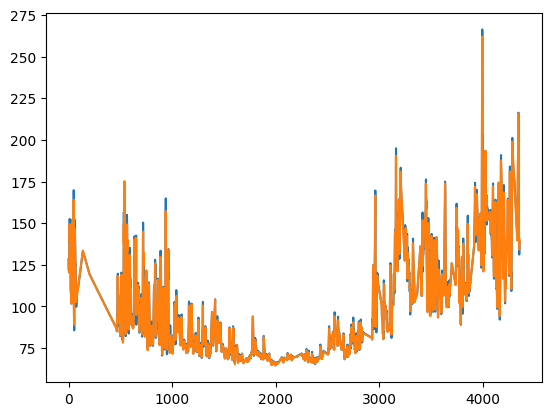

In [39]:
import matplotlib.pyplot as plt
plt.plot(y_preds)
plt.plot(test_y)

In [94]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pathlib

class LSTM2():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'LSTM2.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, lag):
        model = Sequential()
        model.add(LSTM(64, activation='relu', return_sequences= True, input_shape = (lag, 1)))
        model.add(LSTM(32, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')

        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        self.model = model
        print("MLP moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100, lag = 27):
        if self.model == None:
          model =  self.build_model(lag)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        r2 = r2_score(test_y, pred_y)
        rmse = np.sqrt(mean_squared_error(test_y, pred_y))
        print("R2 score:", r2)
        print("RMSE: ", rmse)        
        return r2, rmse, pred_y
    
    
        

        
    def plot(self):
        plt.plot()
          
          

In [45]:
lstm2 =LSTM2()
train_X, train_y, test_X, test_y = get_data()
lstm2.train(train_X, train_y, test_X, test_y)
lstm2




MLP moedel built!
Epoch 1/100


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


262/262 [==============================] - 7s 21ms/step - loss: 2902.7527 - val_loss: 64.1613
Epoch 2/100
262/262 [==============================] - 5s 20ms/step - loss: 132.8681 - val_loss: 59.0096
Epoch 3/100
262/262 [==============================] - 7s 26ms/step - loss: 375.6496 - val_loss: 28.3484
Epoch 4/100
262/262 [==============================] - 6s 22ms/step - loss: 61.8395 - val_loss: 25.5368
Epoch 5/100
262/262 [==============================] - 5s 20ms/step - loss: 51.1828 - val_loss: 22.1060
Epoch 6/100
262/262 [==============================] - 5s 19ms/step - loss: 46.6485 - val_loss: 31.8160
Epoch 7/100
262/262 [==============================] - 5s 19ms/step - loss: 42.2375 - val_loss: 17.4177
Epoch 8/100
262/262 [==============================] - 5s 20ms/step - loss: 40.0419 - val_loss: 20.5892
Epoch 9/100
262/262 [==============================] - 5s 19ms/step - loss: 38.1864 - val_loss: 15.8935
Epoch 10/100
262/262 [==============================] - 5s 19ms/step - l

In [95]:
train_X, train_y, test_X, test_y = get_data()
r2, rmse, y_preds = lstm2.evaluate(test_X = test_X, test_y = test_y)

137/137 [==============================] - 1s 8ms/step
R2 score: 0.9847401230687274
RMSE:  3.6112506484232014


In [96]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pathlib

class LSTM2_multistep():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'LSTM2_multistep.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, in_steps, out_steps):
        model = Sequential()
        model.add(LSTM(64, activation='relu', return_sequences= True, input_shape = (in_steps, 1)))
        model.add(LSTM(32, activation='relu'))
        model.add(Dense(out_steps))
        model.compile(loss='mse', optimizer='adam')

        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        self.model = model
        print("MLP moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100,in_steps = 27, out_steps = 7):
        if self.model == None:
          model =  self.build_model(in_steps= in_steps, out_steps= out_steps)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        RMSE_scores = []
        R2_scores = []    
        for i in range(test_y.shape[1]):
            mse = mean_squared_error(test_y[:, i], pred_y[:,  i])
            rmse = np.sqrt(mse)
            RMSE_scores.append(rmse)
            
        for i in range(test_y.shape[1]):
            r2 = r2_score(test_y[:, i], pred_y[:,  i])        
            R2_scores.append(r2)
            
        total_score = 0
        for row in range(test_y.shape[0]):
            for col in range(pred_y.shape[1]):
                total_score += (test_y[row, col] - pred_y[row, col]**2)
                total_score = np.sqrt(total_score/(test_y.shape[0] * test_y.shape[1]))
                
        return RMSE_scores, R2_scores, total_score, pred_y

    

In [97]:
LSTM2_multistep = LSTM2_multistep()
train_X, train_y, test_X, test_y = get_data_multistep(27,7)
LSTM2_multistep.train(train_X, train_y, test_X, test_y, in_steps= 27, out_steps= 7)

MLP moedel built!
Epoch 1/100


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


261/261 [==============================] - 8s 23ms/step - loss: 12687.4756 - val_loss: 438.3090
Epoch 2/100
261/261 [==============================] - 6s 22ms/step - loss: 1434.5106 - val_loss: 164.8703
Epoch 3/100
261/261 [==============================] - 6s 22ms/step - loss: 534.3317 - val_loss: 147.4663
Epoch 4/100
261/261 [==============================] - 6s 23ms/step - loss: 419.2549 - val_loss: 130.7292
Epoch 5/100
261/261 [==============================] - 6s 23ms/step - loss: 382.9825 - val_loss: 126.1501
Epoch 6/100
261/261 [==============================] - 6s 24ms/step - loss: 348.6004 - val_loss: 120.8141
Epoch 7/100
261/261 [==============================] - 6s 22ms/step - loss: 332.3812 - val_loss: 115.5973
Epoch 8/100
261/261 [==============================] - 6s 23ms/step - loss: 322.8432 - val_loss: 112.7555
Epoch 9/100
261/261 [==============================] - 6s 21ms/step - loss: 315.3603 - val_loss: 112.0321
Epoch 10/100
261/261 [==============================] -

KeyboardInterrupt: 

In [100]:
# train_X, train_y, test_X, test_y = get_data_multistep(27,7)
r2, rmse, total_score, y_preds = LSTM2_multistep.evaluate(test_X = test_X, test_y = test_y)
print("R2 score:", r2)
print("RMSE: ", rmse)  

136/136 [==============================] - 1s 7ms/step
R2 score: [5.569040744042218, 6.077633658596724, 7.230882510524091, 8.752351749838269, 10.021950797778777, 11.187511938800254, 12.20278257374658]
RMSE:  [0.9625902376094795, 0.9554702454266346, 0.9370016270274607, 0.9077516133247489, 0.8791108803496764, 0.8494193047894008, 0.8209147594804774]


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_3412\689974487.py:57: RuntimeWarning: invalid value encountered in sqrt
  total_score = np.sqrt(total_score/(test_y.shape[0] * test_y.shape[1]))


In [65]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

class LSTM3():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'LSTM3.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, lag):
        # Define model
        model = Sequential()
        model.add(LSTM(128,return_sequences= True,  input_shape=(27,1)))
        model.add(LeakyReLU(alpha = 0.5))
        model.add(LSTM(128, return_sequences=True))
        model.add(LeakyReLU(alpha = 0.5))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
        model.add(Dropout(0.3))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')

        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        self.model = model
        print("MLP moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100, lag = 27):
        if self.model == None:
          model =  self.build_model(lag)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        r2 = r2_score(test_y, pred_y)
        rmse = np.sqrt(mean_squared_error(test_y, pred_y))
        print("R2 score:", r2)
        print("RMSE: ", rmse)        
        return r2, rmse, pred_y

        
    def plot(self):
        plt.plot()

In [ ]:
lstm3 =LSTM3()
train_X, train_y, test_X, test_y = get_data()
lstm3.train(train_X, train_y, test_X, test_y)

In [54]:
r2, rmse, y_preds = lstm3.evaluate(test_X = test_X, test_y = test_y)

137/137 [==============================] - 3s 17ms/step
R2 score: -0.002549201229657516
RMSE:  29.270825115073862


In [66]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

class LSTMCNN():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'CNNLSTM2.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, lag):
        # Define model
        
        model_cnn_lstm = Sequential()
        model_cnn_lstm.add(TimeDistributed(Conv1D(filters=16, kernel_size=14, activation='relu'), input_shape=(None, 27, 1)))
        model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=4, activation='relu')))
        model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model_cnn_lstm.add(TimeDistributed(Flatten()))
        model_cnn_lstm.add(Dense(128))
        model_cnn_lstm.add(LSTM(64, activation='relu', return_sequences= True))
        model_cnn_lstm.add(LSTM(32, activation='relu'))
        model_cnn_lstm.add(Dense(1))
        model_cnn_lstm.compile(loss='mse', optimizer='adam')


    # Print the model summary
        optimizer = Adam(lr=0.001)
        model_cnn_lstm.compile(optimizer=optimizer, loss='mse')
        self.model = model_cnn_lstm
        print("moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100, lag = 27):
        if self.model == None:
          model =  self.build_model(lag)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        r2 = r2_score(test_y, pred_y)
        rmse = np.sqrt(mean_squared_error(test_y, pred_y))
        print("R2 score:", r2)
        print("RMSE: ", rmse)        
        return r2, rmse, pred_y

        
    def plot(self):
        plt.plot()

In [69]:
lstm_cnn =LSTMCNN()
train_X, train_y, test_X, test_y = get_data_CNN()
lstm_cnn.train(train_X, train_y, test_X, test_y, epochs=100)

moedel built!
Epoch 1/100


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


262/262 [==============================] - 4s 6ms/step - loss: 1653.9038 - val_loss: 120.5342
Epoch 2/100
262/262 [==============================] - 1s 4ms/step - loss: 304.8667 - val_loss: 103.3963
Epoch 3/100
262/262 [==============================] - 1s 4ms/step - loss: 229.5621 - val_loss: 65.5013
Epoch 4/100
262/262 [==============================] - 1s 4ms/step - loss: 184.1823 - val_loss: 79.6671
Epoch 5/100
262/262 [==============================] - 1s 4ms/step - loss: 160.2560 - val_loss: 54.1204
Epoch 6/100
262/262 [==============================] - 1s 4ms/step - loss: 141.9005 - val_loss: 42.4044
Epoch 7/100
262/262 [==============================] - 1s 4ms/step - loss: 119.3657 - val_loss: 48.7666
Epoch 8/100
262/262 [==============================] - 1s 4ms/step - loss: 108.2964 - val_loss: 39.0499
Epoch 9/100
262/262 [==============================] - 1s 4ms/step - loss: 99.8905 - val_loss: 35.0641
Epoch 10/100
262/262 [==============================] - 1s 4ms/step - loss

In [70]:
r2, rmse, y_preds = lstm_cnn.evaluate(test_X = test_X, test_y = test_y)

137/137 [==============================] - 1s 2ms/step
R2 score: 0.9792255153486535
RMSE:  4.21354121973101


In [106]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

class LSTMCNN_multistep():
    def __init__(self):
        self.model = None
        self.model_root = 'models/'
        self.model_name = 'CNNLSTM2_multisteps.h5'
        self.model_path = self.model_root + self.model_name
        
    def build_model(self, in_steps, out_steps):
        # Define model
        
        model_cnn_lstm = Sequential()
        model_cnn_lstm.add(TimeDistributed(Conv1D(filters=16, kernel_size=14, activation='relu'), input_shape=(None, in_steps, 1)))
        model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=4, activation='relu')))
        model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model_cnn_lstm.add(TimeDistributed(Flatten()))
        model_cnn_lstm.add(Dense(128))
        model_cnn_lstm.add(LSTM(64, activation='relu', return_sequences= True))
        model_cnn_lstm.add(LSTM(32, activation='relu'))
        model_cnn_lstm.add(Dense(out_steps))
        model_cnn_lstm.compile(loss='mse', optimizer='adam')


    # Print the model summary
        optimizer = Adam(lr=0.001)
        model_cnn_lstm.compile(optimizer=optimizer, loss='mse')
        self.model = model_cnn_lstm
        print("moedel built!")
        
        return self.model
    
    def train(self,train_X, train_y, test_X, test_y, verbose = 1, epochs = 100, in_steps = 27, out_steps = 3):
        if self.model == None:
          model =  self.build_model(in_steps= in_steps, out_steps= out_steps)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        model.fit(train_X, train_y, epochs = epochs, verbose = verbose, validation_data = (test_X, test_y), callbacks=[checkpoint])
        self.model = model
          
    def evaluate(self, test_X, test_y):
        model = self.model
        model.load_weights(self.model_path)
        # Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
        pred_y = model.predict(test_X)
        RMSE_scores = []
        R2_scores = []    
        for i in range(test_y.shape[1]):
            mse = mean_squared_error(test_y[:, i], pred_y[:,  i])
            rmse = np.sqrt(mse)
            RMSE_scores.append(rmse)
            
        for i in range(test_y.shape[1]):
            r2 = r2_score(test_y[:, i], pred_y[:,  i])        
            R2_scores.append(r2)
            
        total_score = 0
        for row in range(test_y.shape[0]):
            for col in range(pred_y.shape[1]):
                total_score += (test_y[row, col] - pred_y[row, col]**2)
                total_score = np.sqrt(total_score/(test_y.shape[0] * test_y.shape[1]))
                
        return RMSE_scores, R2_scores, total_score, pred_y

        
    def plot(self):
        plt.plot()

In [107]:
lstm_cnn_multistep =LSTMCNN_multistep()
train_X, train_y, test_X, test_y = get_CNN_data_multistep(in_steps=27, out_steps=7)
lstm_cnn_multistep.train(train_X, train_y, test_X, test_y, epochs=60, in_steps=27, out_steps=7)

moedel built!
Epoch 1/60


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


261/261 [==============================] - 4s 6ms/step - loss: 2731.1006 - val_loss: 178.7089
Epoch 2/60
261/261 [==============================] - 1s 5ms/step - loss: 471.0459 - val_loss: 159.4430
Epoch 3/60
261/261 [==============================] - 1s 5ms/step - loss: 419.3045 - val_loss: 133.4439
Epoch 4/60
261/261 [==============================] - 1s 5ms/step - loss: 383.2812 - val_loss: 146.6740
Epoch 5/60
261/261 [==============================] - 1s 5ms/step - loss: 353.6266 - val_loss: 131.3352
Epoch 6/60
261/261 [==============================] - 1s 5ms/step - loss: 335.9055 - val_loss: 110.3918
Epoch 7/60
261/261 [==============================] - 1s 5ms/step - loss: 320.8566 - val_loss: 116.2676
Epoch 8/60
261/261 [==============================] - 1s 5ms/step - loss: 328.5031 - val_loss: 114.8729
Epoch 9/60
261/261 [==============================] - 1s 5ms/step - loss: 314.5367 - val_loss: 116.7516
Epoch 10/60
261/261 [==============================] - 1s 5ms/step - loss:

In [ ]:
r2, rmse, y_preds = lstm_cnn-MLP_multistep.evaluate(test_X = test_X, test_y = test_y)

In [108]:
print("R2 score:", r2)
print("RMSE: ", rmse)  

R2 score: [5.569040744042218, 6.077633658596724, 7.230882510524091, 8.752351749838269, 10.021950797778777, 11.187511938800254, 12.20278257374658]
RMSE:  [0.9625902376094795, 0.9554702454266346, 0.9370016270274607, 0.9077516133247489, 0.8791108803496764, 0.8494193047894008, 0.8209147594804774]
